In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import sys
import math

from matplotlib import rc
import pandas as pd


import subprocess
import sys
import os

import time

from multiprocessing import Pool

In [134]:
def model_cluster_trip(config_file_name, seed, devnull):
    if sys.version_info > (3, 0):
        return subprocess.run(["./model_cluster_trip_v2", config_file_name, str(seed)],
                stdout=subprocess.PIPE, stderr=devnull).stdout
    else:
        p = subprocess.Popen(["./model_cluster_trip_v2", config_file_name, str(seed)],
                stdout=subprocess.PIPE, stderr=devnull)
        return "".join(p.stdout.readlines())

def graph_generation(baseline_icu,baseline_nodes,baseline_days,scale,scale_days,ext,cluster_size,mu,k,extpop):
    num_icus=int(baseline_icu/scale)#200 baseline
    num_days=int(baseline_days/scaledays) #1200 baseline, we want most, even controlled pandemic to end.
    
    if ext==0:
        with open("config_for_grid_search.json") as f:
            config = json.load(f)
            
        num_nodes=int(baseline_nodes/scale)#1,000,000 baseline
        num_clusters=int(num_nodes/cluster_size)

        config["graph_generation"][0]["num_people_per_cluster"]=cluster_size
        config["graph_generation"][0]["num_clusters"]=num_clusters
        
    if ext==1 or ext==2: # superspreaders model and/or domovi model
        if ext==1:
            with open("config_for_grid_search_superspreaders.json") as f:
                config = json.load(f)
        if ext==2:
            with open("config_for_grid_search_domovi.json") as f:
                config = json.load(f)

        num_nodes0=int((baseline_nodes-extpop)/scale)#1,000,000 baseline
        num_clusters0=int(num_nodes0/cluster_size)

        num_nodes1=int(extpop/scale)
        num_clusters1=int(num_nodes1/cluster_size)

        config["graph_generation"][0]["num_people_per_cluster"]=cluster_size
        config["graph_generation"][0]["num_clusters"]=num_clusters0

        config["graph_generation"][1]["num_people_per_cluster"]=cluster_size
        config["graph_generation"][1]["num_clusters"]=num_clusters1
        
        a=config["graph_generation"][0]["category_ratios"][0]
        b=config["graph_generation"][0]["category_ratios"][1]
        
        if ext==1:
            config["graph_generation"][0]["category_ratios"][0]=int(baseline_nodes*(a/(a+b))/scale-num_nodes1) # diminish <60 because some are superspreaders
            config["graph_generation"][0]["category_ratios"][1]=int(baseline_nodes*(b/(a+b))/scale)
        if ext==2:
            config["graph_generation"][0]["category_ratios"][0]=int(baseline_nodes*(a/(a+b))/scale) 
            config["graph_generation"][0]["category_ratios"][1]=int(baseline_nodes*(b/(a+b))/scale-num_nodes1) # diminish >=60 because some are in domovi
            
    config["simulation"]["stopping_conditions"]["num_days"]=num_days
    config["simulation"]["num_icus"]=num_icus
    config["simulation"]["mu"] = mu
    config["simulation"]["k_trip"] = k
    config["simulation"]["events"][0]["update_params"]["prob_s_to_i"]=[el * scale for el in config["simulation"]["events"][0]["update_params"]["prob_s_to_i"]]
    
    return config

def grid_search_parameters(config,p1,p2,ext,k,mu,cluster_size,seed):
    config["simulation"]["initial_params"][0]["prob_goes_on_trip"] = p1
    config["simulation"]["initial_params"][1]["prob_goes_on_trip"] = p1
    config["simulation"]["initial_params"][0]["prob_c_neighbour_trip_candidate"] = p2
    config["simulation"]["initial_params"][1]["prob_c_neighbour_trip_candidate"] = p2
    
    if ext==0:
        config_file_name = "tmp/Base_tmp_config_rgs{}_{}_{}_{}.json".format(
            k, mu, cluster_size, seed)
    if ext==1:
        config_file_name = "tmp/Superspreaders_tmp_config_rgs{}_{}_{}_{}_extpop{}.json".format(
                k, mu, cluster_size, seed, extpop)
    if ext==2:
        # >=60 in domovi 10 times more likely to be in quarantine and 10 times more likely not to go on trip.
        config["simulation"]["initial_params"][2]["prob_goes_on_trip"] = p1/10 
        config["simulation"]["initial_params"][2]["prob_c_neighbour_trip_candidate"] = p2/10

        config_file_name = "tmp/Domovi_tmp_config_rgs{}_{}_{}_{}_extpop{}.json".format(
                k, mu, cluster_size, seed, extpop)
    return [config, config_file_name]



In [188]:
scale=1 #1 if real simul
scaledays=1

p1=0.7
p2=0.85
ext=1
extpop=100
k=2.5
mu=5
cluster_size=2
seed=0

config=graph_generation(200,1000000,1200,scale,scaledays,ext,cluster_size,mu,k,extpop)


devnull = open(os.devnull, 'w')

config_list=grid_search_parameters(config,p1,p2,ext,k,mu,cluster_size,seed)
config=config_list[0]
config_file_name=config_list[1]

with open(config_file_name, "w") as f:
    json.dump(config, f, indent=4)

print("Running model with params: cluster_size = {:.3f}".format(cluster_size),
      ", prob_goes_on_trip = {:.3f}".format(p1),
      ", prob_c_neighbour_trip_candidate = {:.3f}".format(p2),
      "seed = {}".format(seed), file=sys.stderr)
stdout = model_cluster_trip(config_file_name, seed, devnull)

# chance of StopIteration is ((2.999999)^{10^6})^30 = 10^{-13}.
output=json.loads(stdout)
os.remove(config_file_name)
devnull.close()

Running model with params: cluster_size = 2.000 , prob_goes_on_trip = 0.700 , prob_c_neighbour_trip_candidate = 0.850 seed = 0


In [334]:
print(output)

{'first_day_icu_overflow': -1, 'last_day_icu_overflow': -1, 'num_days_icu_overflow': 0, 'stats': {'confirmed': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 7, 12, 16, 18, 20, 25, 27, 30, 31, 35, 38, 41, 44, 50, 56, 60, 61, 71, 81, 95, 104, 112, 120, 126, 126, 131, 138, 143, 142, 142, 146, 151, 156, 164, 168, 172, 176, 177, 194, 201, 204, 208, 206, 203, 193, 192, 192, 197, 213, 200, 195, 203, 200, 206, 211, 225, 230, 244, 249, 251, 268, 287, 295, 297, 303, 313, 306, 304, 298, 282, 258, 241, 225, 204, 196, 187, 177, 168, 165, 156, 164, 173, 170, 165, 174, 176, 175, 168, 172, 173, 169, 160, 156, 159, 158, 158, 158, 150, 161, 172, 175, 196, 221, 238, 263, 286, 299, 327, 350, 354, 358, 374, 366, 358, 363, 355, 354, 358, 354, 356, 369, 373, 363, 400, 411, 420, 433, 461, 484, 486, 495, 496, 523, 542, 538, 548, 557, 573, 571, 570, 586, 598, 617, 619, 643, 666, 709, 736, 751, 746, 746, 745, 738, 724, 725, 725, 716, 701, 686, 652, 665, 676, 684, 699, 725, 736, 764,

In [190]:
#with open('config_for_grid_search.json', 'r') as f:
#    config = json.load(f)
#with open('output.json', 'r') as f:
#    data1 = json.load(f)

data1=output

# "mild" is better name than "confirmed" since people in "icu" state are also
# confirmed cases in the real world
data=data1["stats"]
data["mild"] = data["confirmed"]
del data["confirmed"]

a=config["simulation"]["initial_params"][0]["prob_goes_on_trip"]
b=config["simulation"]["initial_params"][0]["prob_c_neighbour_trip_candidate"]
c=config["simulation"]["mu"]
d=config["graph_generation"][0]["num_clusters"]
e=config["graph_generation"][0]["num_people_per_cluster"]
print("prob_goes_on_trip = ",a)
print("prob_c_neighbour_trip_candidate = ",b)
print("Mu = ", c)
print("num clusters = ", d)
print("num people per cluster = ", e)

prob_goes_on_trip =  0.7
prob_c_neighbour_trip_candidate =  0.85
Mu =  5
num clusters =  499950
num people per cluster =  2


In [191]:
#sansa da ovdje izleti stopiteration jer se niko nije zarazio je ((0.999999)^{10^6})^30 = 10^{-13}, ali evo try. :D
try:
    beginning_pandemic = next(x for x, val in enumerate(data1["stats"]["infectious"]) if val > 0)
except StopIteration:
    beginning_pandemic = 15
    end_pandemic = 15
    len_pandemic = 0
else:    
    beginning_pandemic = next(x for x, val in enumerate(data1["stats"]["infectious"]) if val > 0)
    end_pandemic = len((data1["stats"]["mild"])) - 1 - next(x for x, val in enumerate(reversed(data1["stats"]["mild"])) if val > 0 )
    #end_pandemic = next(x for x, val in enumerate(data1["stats"]["mild"]) if (val == 0 and x > beginning_pandemic + 10) )
    len_pandemic = end_pandemic - beginning_pandemic + 1
peak_corona_total = max([sum(x) for x in zip( (data1["stats"]["infectious"]),(data1["stats"]["mild"]), (data1["stats"]["icu"]))])
peak_corona_system_load = max([sum(x) for x in zip( (data1["stats"]["mild"]), (data1["stats"]["icu"]))])
corona_deaths = data1["stats"]["dead"][-1]
no_corona_deaths = data1["stats"]["nocorona_dead"][-1]

print("beginning pandemic = ",beginning_pandemic) # first index is 0.
print("length pandemic = ",len_pandemic)
print("peak corona total = ",peak_corona_total)
print("peak corona known (mild+ic) = ",peak_corona_system_load)
print("corona deaths total = ",corona_deaths)
print("no_corona deaths total= ",no_corona_deaths)



beginning pandemic =  16
length pandemic =  1058
peak corona total =  2155
peak corona known (mild+ic) =  1507
corona deaths total =  520
no_corona deaths total=  2622


In [8]:
croatiaresp=int(34/4)
croatiadeaths=int(31/4)

croatia_now_resp = next(x for x, val in enumerate(data1["stats"]["icu"]) if val > croatiaresp)
croatia_now_deaths = next(x for x, val in enumerate(data1["stats"]["dead"]) if val > croatiadeaths)

print("Day in pandemic for respirators = ",croatia_now_resp)
print("Day in pandemic for deaths = ",croatia_now_deaths)

corona_total = [sum(x) for x in zip( (data1["stats"]["infectious"]),(data1["stats"]["mild"]), (data1["stats"]["icu"]))]
print("Croatia's Total number of cases is in the range = ",
      4*min(corona_total[croatia_now_resp],corona_total[croatia_now_deaths]), "-",
      4*max(corona_total[croatia_now_resp],corona_total[croatia_now_deaths]))

Day in pandemic for respirators =  77
Day in pandemic for deaths =  91
Croatia's Total number of cases is in the range =  14348 - 28256


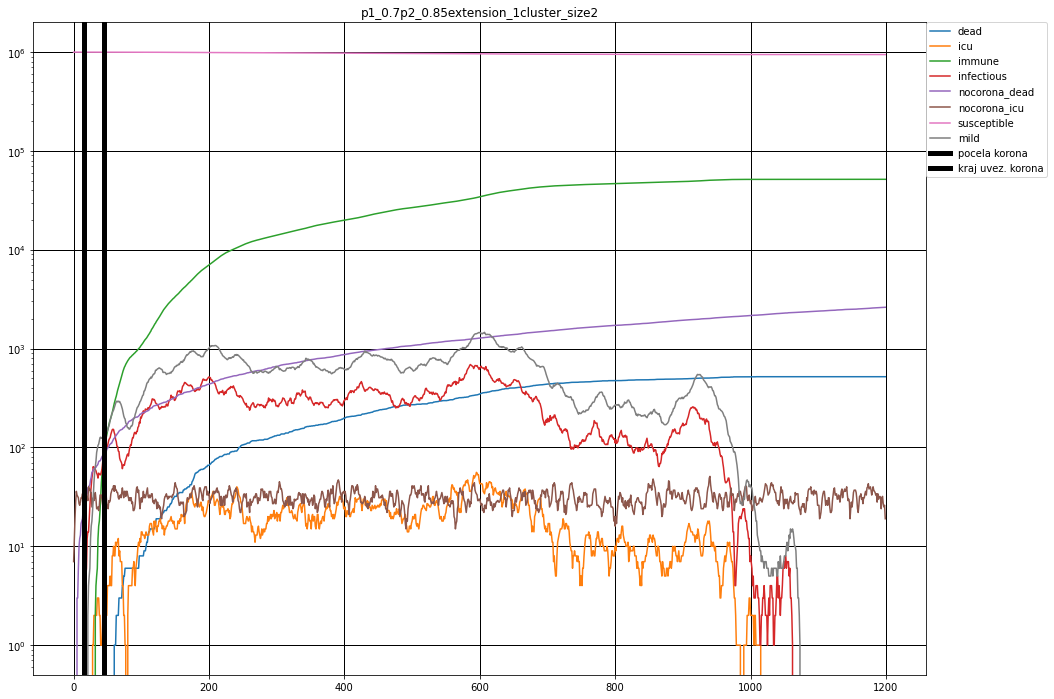

In [192]:
for state in data:
    plt.plot(np.arange(len(data[state])), data[state], label=state)
for event in config["simulation"]["events"]:
    plt.axvline(x=event["day"], label=event["label"],color="k", linewidth=5)

        
figure = plt.gcf() # get current figure
figure.set_size_inches(16, 12)
plt.title("p1_"+str(p1)+"p2_"+str(p2)+"extension_"+str(ext)+"cluster_size"+str(cluster_size))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
plt.yscale("log")
plt.grid(color='k', linestyle='-', linewidth=1)
#plt.show()

plt.savefig('outputsBilj/logplot_superspreaders_pmobility'+str(a)+'pquarmis'+str(b)+'.png')

In [140]:
diffdead=[t - s for s, t in zip(data['dead'], data['dead'][1:])]
diffnocoronadead=[t - s for s, t in zip(data['nocorona_dead'], data['nocorona_dead'][1:])]
print('corona_deaths = ',sum(diffdead))
print('nocorona_deaths = ',sum(diffnocoronadead))
print('total_deaths = ',sum(diffdead)+sum(diffnocoronadead))

corona_deaths =  520
nocorona_deaths =  2622
total_deaths =  3142


<function matplotlib.pyplot.show(*args, **kw)>

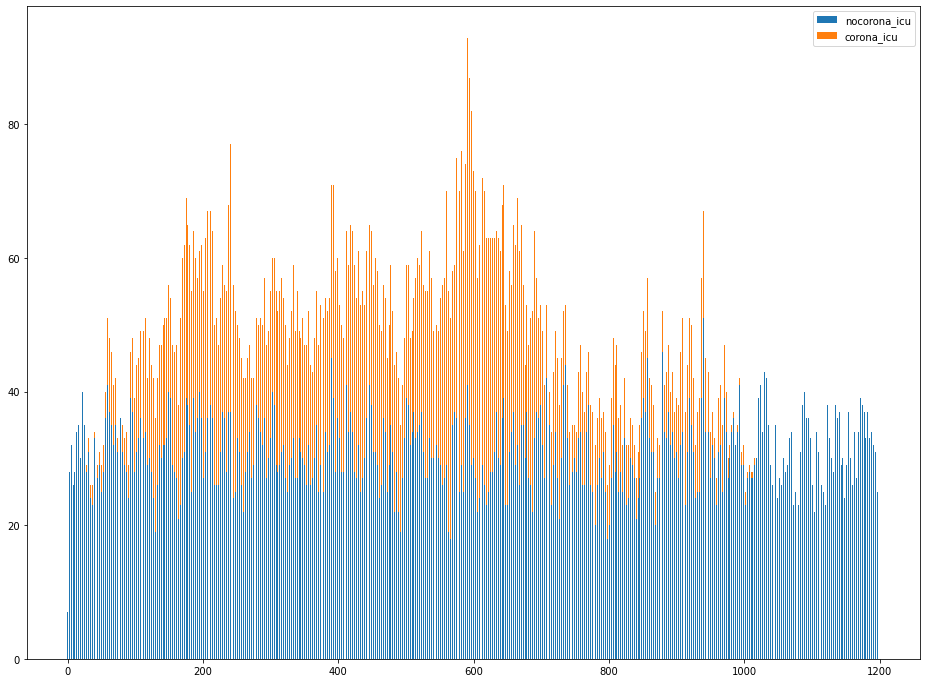

In [141]:
# y-axis in bold
#rc('font', weight='normal')

width=0.5
 
# Create brown bars
item1=plt.bar(np.arange(len(data['nocorona_icu'])), data['nocorona_icu'],width=width)
# Create green bars (middle), on top of the firs ones
item2=plt.bar(np.arange(len(data['icu'])), data['icu'], bottom=data['nocorona_icu'],width=width)
# Create green bars (top)
 
# Custom X axis
figure = plt.gcf() # get current figure
figure.set_size_inches(16, 12)
plt.legend([item1, item2], ['nocorona_icu','corona_icu'])
plt.show
#plt.savefig('outputsBilj/icutotal_ptrip'+str(a)+'pdisobedient'+str(b)+'mu'+str(c)+'.png')

<function matplotlib.pyplot.show(*args, **kw)>

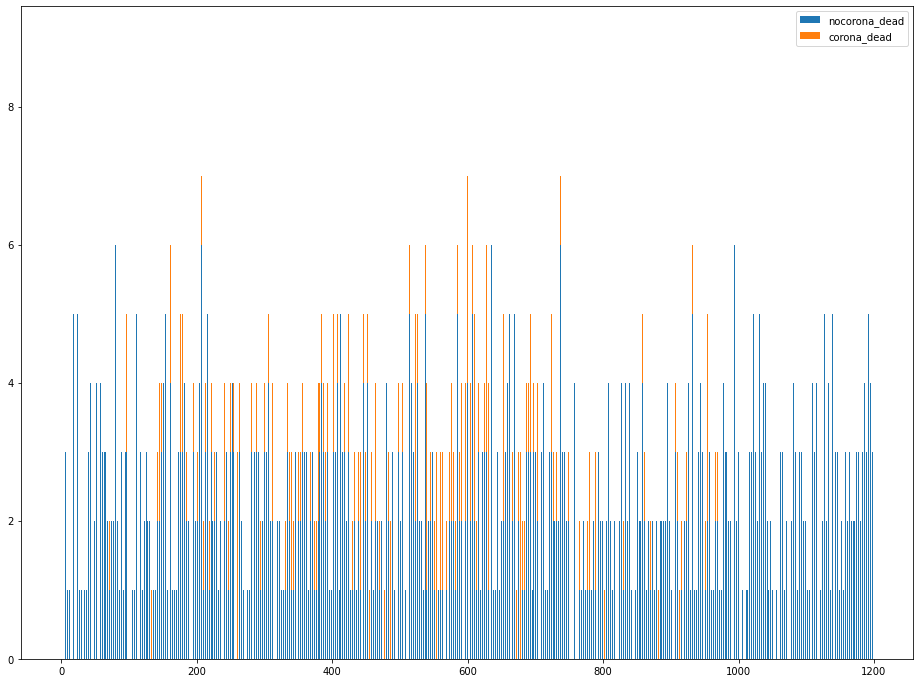

In [142]:
# y-axis in bold
#rc('font', weight='normal')
 
# Create brown bars
item1=plt.bar(np.arange(len(diffnocoronadead)), diffnocoronadead,width=width)
# Create green bars (middle), on top of the firs ones
item2=plt.bar(np.arange(len(diffdead)), diffdead, bottom=diffnocoronadead,width=width)
# Create green bars (top)
 
# Custom X axis
figure = plt.gcf() # get current figure
figure.set_size_inches(16, 12)
plt.legend([item1, item2], ['nocorona_dead','corona_dead'])
plt.show
#plt.savefig('outputsBilj/deadtotal_ptrip'+str(a)+'pdisobedient'+str(b)+'mu'+str(c)+'.png')

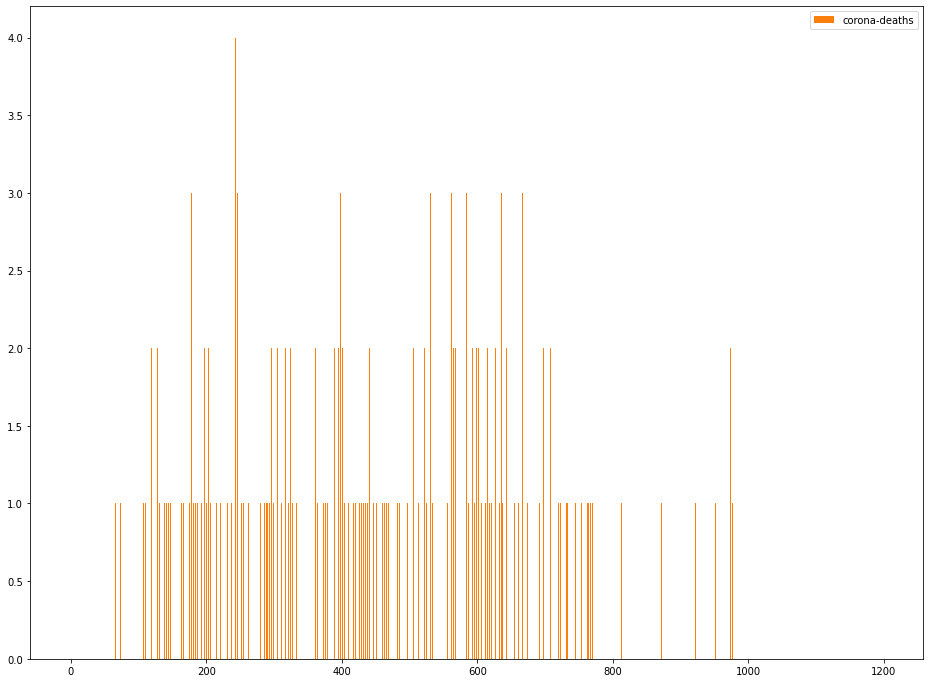

In [143]:
plt.bar(np.arange(len(diffdead)),diffdead,label='corona-deaths',color='C1',width=width)
#plt.plot(np.arange(len(diffdead)),diffdead,label='corona-deaths',color='C1')
figure = plt.gcf() # get current figure
figure.set_size_inches(16, 12)
plt.legend()
plt.show()
#plt.savefig('corona_deaths.png')

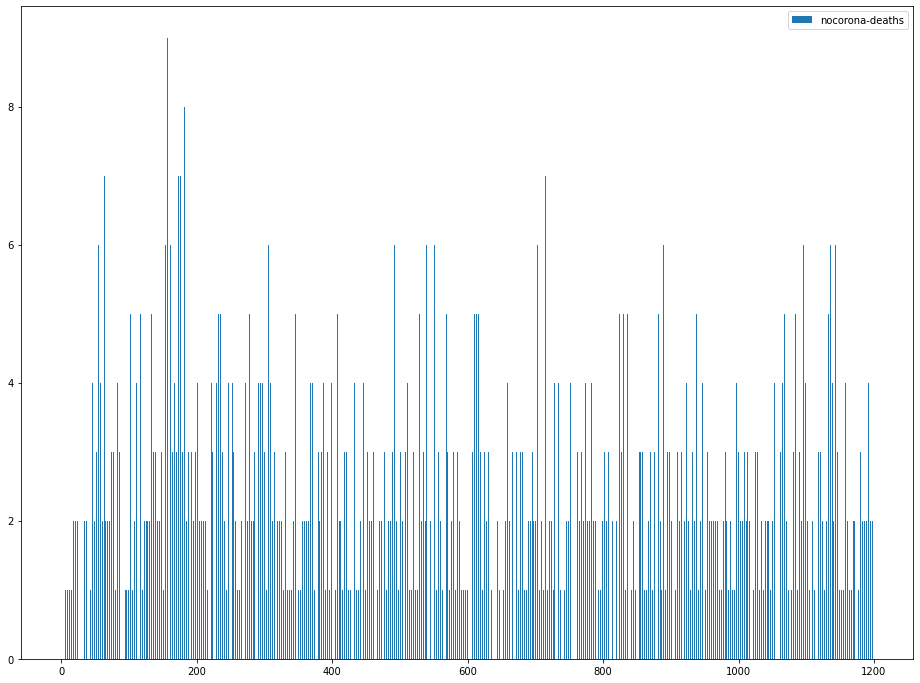

In [17]:
plt.bar(np.arange(len(diffnocoronadead)), diffnocoronadead, label='nocorona-deaths',color='C0',width=width)
#plt.plot(np.arange(len(diffnocoronadead)),diffdead,label='nocorona-deaths',color='C0')
figure = plt.gcf() # get current figure
figure.set_size_inches(16, 12)
plt.legend()
plt.show()
#plt.savefig('nocorona_deaths.png')

## From Mu

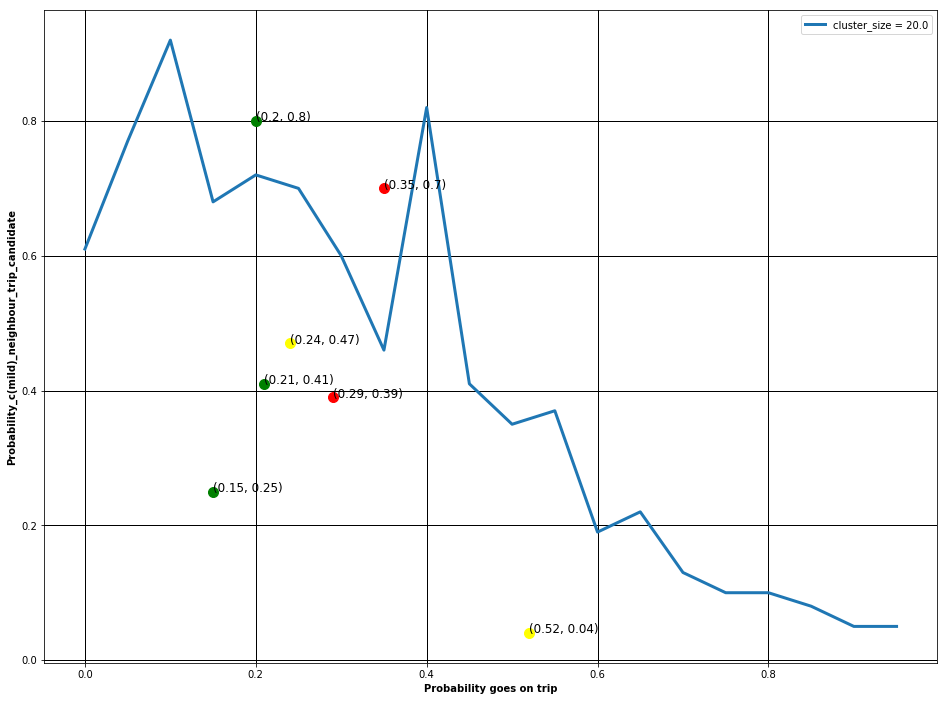

In [135]:
#rc('font', weight='bold')
h=19#15 je mu=5
for i in range(h,h+1):
#for i in range(0,len(list(mu_dict.keys()))-8):
    res = list(mu_dict.keys())[i]
    #rc('font', weight='normal')
    #plt.figure(figsize=(16,10))
    plt.plot([round(float(k),2) for k in mu_dict[res].keys()], [round(np.sum(mu_dict[res][k])/len(seeds),2) for k in mu_dict[res].keys()], 
             color='C'+str(i-h), linewidth=3,label='cluster_size = {}'.format(round(res,2)))
    plt.plot(0.21, 0.41, color='green', marker='o', linestyle='dashed',linewidth=2, markersize=10)
    plt.plot(0.15, 0.25, color='green', marker='o', linestyle='dashed',linewidth=2, markersize=10)
    plt.plot(0.2, 0.8, color='green', marker='o', linestyle='dashed',linewidth=2, markersize=10)
    plt.plot(0.35, 0.7, color='red', marker='o', linestyle='dashed',linewidth=2, markersize=10)
    plt.plot(0.29, 0.39, color='red', marker='o', linestyle='dashed',linewidth=2, markersize=10)
    plt.plot(0.24, 0.47, color='yellow', marker='o', linestyle='dashed',linewidth=2, markersize=10)
    plt.plot(0.52, 0.04, color='yellow', marker='o', linestyle='dashed',linewidth=2, markersize=10)
    plt.text(0.21, 0.41, "(0.21, 0.41)", fontsize=12)
    plt.text(0.15, 0.25, "(0.15, 0.25)", fontsize=12)
    plt.text(0.2, 0.8, "(0.2, 0.8)", fontsize=12)
    plt.text(0.35, 0.7, "(0.35, 0.7)", fontsize=12)
    plt.text(0.29, 0.39, "(0.29, 0.39)", fontsize=12)
    plt.text(0.52, 0.04, "(0.52, 0.04)", fontsize=12)
    plt.text(0.24, 0.47, "(0.24, 0.47)", fontsize=12)
    #plt.title('Success border for MU = {}'.format(round(res,2)))
    plt.xlabel('Probability goes on trip',weight='bold')
    plt.ylabel('Probability_c(mild)_neighbour_trip_candidate',weight='bold')
    plt.legend()
    plt.grid(color='k', linestyle='-', linewidth=1)
    #fig = matplotlib.pyplot.gcf()
    #fig.set_size_inches(18.5, 10.5)
    figure = plt.gcf() # get current figure
    figure.set_size_inches(16, 12)

plt.savefig('outputsBilj/mu_5critbound.png')

# EXTRACTION FROM FOLDERS

In [3]:
from os import listdir
from os.path import isfile, join


def find_file_by_name(onlyfiles,string):
    res = [i for i in onlyfiles if string in i]
    for i in res:
        try:
            i = res.index(string)
        except ValueError:
            i=0
        else:
            i = res.index(string)
            del res[i]
    res=[]
            
def change_dodatak(dodatak):
    if str(dodatak)=="base":
        dodatak="Base"
    if str(dodatak)=="superspreaders":
        dodatak="Superspreaders"
    if str(dodatak)=="domovi":
        dodatak="Domovi"
    return dodatak
    
    
def get_files2(initialpath,extrapath,mu,extpop,k=2):
    os.chdir(initialpath) # put path where you have all the needed folders.
    #print(os.getcwd())
    mypath=os.getcwd()+extrapath
    os.chdir(mypath)
    #print(os.getcwd())
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    
    find_file_by_name(onlyfiles,".gitignore")
    find_file_by_name(onlyfiles,".zip")
    
    dodatak=change_dodatak(extrapath[9:-6])   
    if dodatak=="Base":
        extrastr=dodatak+"_real_grid_search_k_trip"+str(k)+"_mu"+str(mu)+"_cluster_size"
    else:
        extrastr=dodatak+"_real_grid_search_extpop"+str(extpop)+"_k_trip"+str(k)+"_mu"+str(mu)+"_cluster_size"

        
    smaller_list=[s for s in onlyfiles if extrastr in s]
    #print("smaller_list = ", smaller_list,"\n")
    
# extract dictionary in string form
    mu_dict_str={}
    for name in smaller_list:
        res=(name[len(extrastr):-5])
        with open(name) as f:
            mu_dict_str[res] = json.load(f)

# convert dictionary to float form    
    dict_float={}
    for res in mu_dict_str.keys():  
        p1_dict_float={}
        for p1 in mu_dict_str[res].keys():
            p2_dict_float={}
            for p2 in mu_dict_str[res][p1].keys():
                p2f=float(p2)
                p2_dict_float[p2f]=mu_dict_str[res][p1][p2]
            p1f=float(p1)
            p1_dict_float[p1f]=p2_dict_float
        resf=float(res)
        dict_float[resf]=p1_dict_float    
                    
# numerically sort each keys in float form dictionary    
    dict_sorted={}                
    for res in sorted(dict_float.keys()):  
        p1_dict_sorted={}               
        for p1 in sorted(dict_float[res].keys()):
            p2_dict_sorted={}
            for p2 in sorted(dict_float[res][p1].keys()):
                p2_dict_sorted[float(p2)]=dict_float[res][p1][p2]            
            p1_dict_sorted[float(p1)]=p2_dict_sorted            
        dict_sorted[float(res)]=p1_dict_sorted

# restore the path
    mypath = mypath[0:-len(extrapath)]
    os.chdir(mypath)
    # print(os.getcwd())
    return dict_sorted


def getfile_crit(initialpath,extrapath,mu,extpop,k=2):
    os.chdir(initialpath) # put path where you have all the needed folders.
    #print(os.getcwd())
    mypath=os.getcwd()+extrapath
    os.chdir(mypath)
    #print(os.getcwd())
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
        
    find_file_by_name(onlyfiles,".gitignore")
    find_file_by_name(onlyfiles,".zip")
    
    dodatak=change_dodatak(extrapath[9:-6])
    if dodatak=="Base":
        extrastr=dodatak+"_crit_bound_search_k_trip"+str(k)+"_mu"+str(mu)+"_cluster_size"
    else:
        extrastr=dodatak+"_crit_bound_search_extpop"+str(extpop)+"_k_trip"+str(k)+"_mu"+str(mu)+"_cluster_size"
  
    smaller_list=[s for s in onlyfiles if extrastr in s]
    #print("smaller_list = ", smaller_list,"\n")
            
    mu_dict_str={}
    for name in smaller_list:
        res=(name[len(extrastr):-5])
        with open(name) as f:
            mu_dict_str[res] = json.load(f)
            
# restore the path          
    mypath = mypath[0:-len(extrapath)]
    os.chdir(mypath)
    return mu_dict_str

In [3]:
def test_crit_bound(res):
    krnjetak=list(np.arange(cluster_dict_crit[str(res)]["p1_vrijednosti"][-1]+0.005,1.0000001,0.005))
    print(cluster_dict_crit[str(res)]["p1_vrijednosti"][-1])
    p1_crit=cluster_dict_crit[str(res)]["p1_vrijednosti"]+krnjetak
    print(p1_crit)
    print(len(krnjetak))
    print(len(p1_crit))
    p2_crit=cluster_dict_crit[str(res)]["p2_vrijednosti"]+[-0.02]*len(krnjetak)
    print(len(p2_crit))
test_crit_bound(int(4.0))

NameError: name 'cluster_dict_crit' is not defined

In [157]:
# cluster_dict : p1_dict : p2_dict : [seed_dict : [list of 8 elements], ratio_of_success_seeds]
        #1 first day of infectious case,2 length of pandemic (first infectious, last mild case),
        #3 peak of pandemic (max (infectious+mild+ic) ) 4 peak of pandemic known cases,
        #5 total corona deaths, 6 total no_corona deaths
        #7  n days in system overload ,8 11st day system overload
        
def get_name(parameter):
    if parameter==0:
        name="Pandemic_begin"
    if parameter==1:
        name="Pandemic_length"
    if parameter==2:
        name="Pandemic_peak"
    if parameter==3:
        name="Pandemic_known_peak"
    if parameter==4:
        name="Total_corona_deaths"
    if parameter==5:
        name="Total_nocorona_deaths"
    if parameter==6:
        name="Sys_overload_length"
    if parameter==7:
        name="Sys_overload_begin"
    if parameter==8:
        name="Pandemic_rel_increase_nocorona_deaths"
    return name

def arange_plot(cluster_dim,parameter,cluster_dict,cluster_dict_crit):
    implista=[]
    p1_list=[]
    p2_list=[]
    
    
    h = list(cluster_dict.keys()).index(cluster_dim) #gets the position of cluster_dim
    res = list(cluster_dict.keys())[h]
    # zna biti potrebno!
    res=int(res)
    
    array = np.zeros((len(cluster_dict[res].keys()), len(cluster_dict[res][0].keys())))

    p1_crit=[]
    p2_crit=[]
    for p1 in cluster_dict[res].keys():
        p1_crit.append(p1)
        p2_crit.append(-0.02)
        for p2 in cluster_dict[res][p1].keys():

            important_list=cluster_dict[res][p1][p2][0][str(0)] #seed 0.
            
            if parameter<=7:
                implista.append(important_list[parameter]) #0-7 range
                p1_list.append(p1)
                p2_list.append(p2)
                
                array[int(p2*20)][int(p1*20)]=important_list[parameter]
                
            if parameter==8:
                minimal_imp_list=cluster_dict[res][0][0][0][str(0)]
                daily_nc_dead_Nopandemic=float(minimal_imp_list[5])/1194
                if important_list[1]<=100:
                    daily_nc_dead_pandemic=0
                else:
                    daily_nc_dead_pandemic=float((important_list[5]-minimal_imp_list[5]))/important_list[1]
                #expected_daily_deaths=6.18*(1-important_list[4]/1000000/2)*0.36
                implista.append(daily_nc_dead_pandemic/daily_nc_dead_Nopandemic)
                p1_list.append(p1)
                p2_list.append(p2)
                
                array[int(p2*20)][int(p1*20)]=daily_nc_dead_pandemic/daily_nc_dead_Nopandemic
            
            if important_list[6]<=0:
                p2_crit.pop()
                p2_crit.append(p2)
    
    # KREIRANJE LOSEG BOUND INTERVALA PREKO GRID_STEP = 0.05
    #plt.plot(p1_crit, p2_crit, color="black", marker='o', linestyle='solid',linewidth=2, markersize=5)
    
    # KREIRANJE FINIJEG BOUND INTERVALA PREKO GRID_STEP=0.005  
    krnjetak=list(np.arange(cluster_dict_crit[str(res)]["p1_vrijednosti"][-1]+0.005,1.0000001,0.005))
    p1_crit=cluster_dict_crit[str(res)]["p1_vrijednosti"]+krnjetak
    p2_crit=cluster_dict_crit[str(res)]["p2_vrijednosti"]+[-0.0]*len(krnjetak)
    
    p1_list_np=np.array(p1_list)
    p2_list_np=np.array(p2_list)
    implista_np=np.array(implista)
    
    return [p1_crit,p2_crit,p1_list_np,p2_list_np,implista_np,array]
    #plt.savefig('outputsBilj/clusters_grid/mu_100/'+'fine_grid'+file_title+'.png')
    #plt.savefig('outputsBilj/clusters_grid/cluster_trip_model_v2/'+'Modelv2_fine_grid'+file_title+'.png')
    #plt.close(figure)

def plot_grid(cluster_dim,parameter,mu,k,extpop,cluster_dict,cluster_dict_crit,type_ext):
    name=get_name(parameter)
    
    out=arange_plot(cluster_dim,parameter,cluster_dict,cluster_dict_crit)
    p1_crit=out[0]
    p2_crit=out[1]
    p1_list_np=out[2]
    p2_list_np=out[3]
    implista_np=out[4]
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    # Major ticks every 20, minor ticks every 5
    major_ticks = np.arange(0, 1.01, 0.05)
    minor_ticks = np.arange(0, 1.01, 0.01)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    # And a corresponding grid
    ax.grid(which='both')

    plt.plot(p1_crit, p2_crit, color="black", marker='o', linestyle='solid',linewidth=1, markersize=1)
    #implista_np=np.log10(implista_np)
    plt.scatter(p1_list_np, p2_list_np, label=None,
    c=implista_np, cmap='rainbow', linewidth=12, alpha=5) #cmap='Accent' good alpha=5

    plt.colorbar(label='INTENSITY MAP')
    plt.clim(math.floor(min(implista_np)), math.ceil(max(implista_np)))

    file_title=(type_ext.capitalize()+"_Model : " + name + ', Cluster_Size = {}'.format(cluster_dim) + 
                " , K = {}".format(k) + ' , MU = {}'.format(mu) 
                + ' , Special_pop = {:.2f} % '.format(float(extpop/10000)))
    plt.title(file_title)
    plt.xlabel('Probability of mobility',weight='bold')
    plt.ylabel('Probability of quarantine misbehaviour',weight='bold')
    
    #plt.imshow(p1_list_np, p2_list_np,interpolation="gaussian")

    figure = plt.gcf() # get current figure
    figure.set_size_inches(16, 12)
    plt.savefig('outputsBilj/'+file_title+'.png')
    
def plot_grid_v2(cluster_dim,parameter,mu,k,extpop,cluster_dict,cluster_dict_crit,type_ext):
    name=get_name(parameter)
    
    out=arange_plot(cluster_dim,parameter,cluster_dict,cluster_dict_crit)
    p1_crit=out[0]
    p2_crit=out[1]    
    implista_np=out[4]
    array=out[5]


    # Major ticks every 20, minor ticks every 5

    plt.imshow(array,interpolation="bicubic",cmap='rainbow',origin="lower",extent=[0,1,0,1])
    plt.plot(p1_crit, p2_crit, color="black", marker='o', linestyle='solid',linewidth=1, markersize=1)
    #implista_np=np.log10(implista_np)
    
    plt.colorbar(label='INTENSITY MAP')
    plt.clim(math.floor(min(implista_np)), math.ceil(max(implista_np)))

    file_title=(type_ext.capitalize()+"_Model : " +name + ', Cluster_Size = {}'.format(cluster_dim) + 
                " , K = {}".format(k) + ' , MU = {}'.format(mu) 
                + ' , Special_pop = {:.2f} % '.format(float(extpop/10000)))
    plt.title(file_title)
    plt.xlabel('Probability of mobility',weight='bold')
    plt.ylabel('Probability of quarantine misbehaviour',weight='bold')
    

    figure = plt.gcf() # get current figure
    figure.set_size_inches(18, 14)
    plt.savefig('outputsBilj/'+file_title+"v2"+'.png')
        
        

cluster_size =  1 feature_number =  0
cluster_size =  1 feature_number =  1
cluster_size =  1 feature_number =  2
cluster_size =  1 feature_number =  3
cluster_size =  1 feature_number =  4
cluster_size =  1 feature_number =  5
cluster_size =  1 feature_number =  6
cluster_size =  1 feature_number =  7
cluster_size =  2 feature_number =  0
cluster_size =  2 feature_number =  1
cluster_size =  2 feature_number =  2
cluster_size =  2 feature_number =  3
cluster_size =  2 feature_number =  4
cluster_size =  2 feature_number =  5
cluster_size =  2 feature_number =  6
cluster_size =  2 feature_number =  7
cluster_size =  3 feature_number =  0
cluster_size =  3 feature_number =  1
cluster_size =  3 feature_number =  2
cluster_size =  3 feature_number =  3
cluster_size =  3 feature_number =  4
cluster_size =  3 feature_number =  5
cluster_size =  3 feature_number =  6
cluster_size =  3 feature_number =  7
cluster_size =  4 feature_number =  0
cluster_size =  4 feature_number =  1
cluster_size

ValueError: 25 is not in list

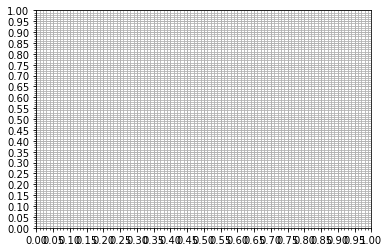

In [131]:
# cluster_dict : p1_dict : p2_dict : [seed_dict : [list of 8 elements], ratio_of_success_seeds]
        #0 first day of infectious case,1 length of pandemic (first infectious, last mild case),
        #2 peak of pandemic (max (infectious+mild+ic) ) 3 peak of pandemic known cases,
        #4 total corona deaths, 5 total no_corona deaths
        #6  n days in system overload ,7 11st day system overload
os.chdir("C:/Users/User/covid19")
cluster_sizes=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,20,25,30,35,40,45,50,100,200,500,1000,5000,10000]
for cluster in cluster_sizes: # ima ih 30 trenutno
    for feature in range(0,8):
        print("cluster_size = " ,cluster, "feature_number = ", feature)
        mu=100 #miky ovo koristio!
        plot_grid(cluster,feature,mu,k,cluster_dict,cluster_dict_crit)

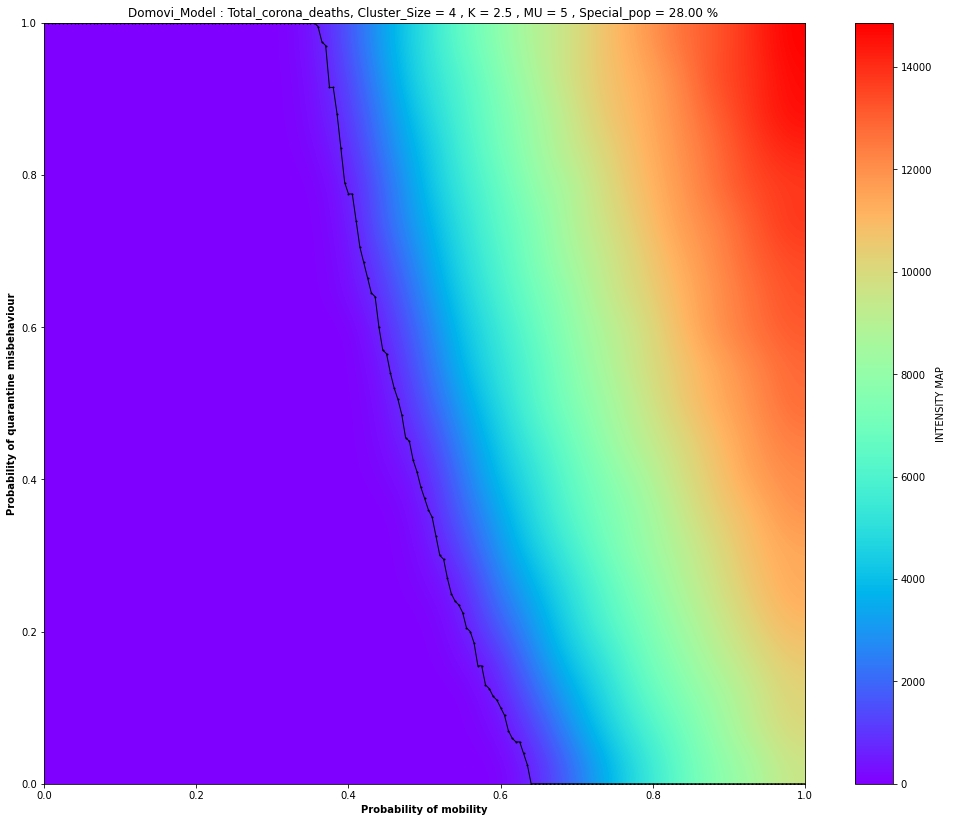

In [245]:
# cluster_dict : p1_dict : p2_dict : [seed_dict : [list of 8 elements], ratio_of_success_seeds]
        #0 first day of infectious case,1 length of pandemic (first infectious, last mild case),
        #2 peak of pandemic (max (infectious+mild+ic) ) 3 peak of pandemic known cases,
        #4 total corona deaths, 5 total no_corona deaths
        #6 number days in system overload ,7 first day system overload , 8 nocorona death increase

mu=5 # 5, 100
k=2.5 # 1,2,5,10
extpop=280000# 100,1000,10000,100000
initialpath=os.getcwd()
#initialpath="/home/dorian/Codes/covid19"
cluster_dict={}
cluster_dict_crit={}

#path_to_open="/outputs/cluster_trip_model_v2"
#path_to_open="/outputs/base_model"
#path_to_open="/outputs/superspreaders_model"
mod="domovi"
path_to_open="/outputs/"+mod+"_model"

cluster_dict=get_files2(initialpath,path_to_open,mu,extpop,k)
cluster_dict_crit=getfile_crit(initialpath,path_to_open,mu,extpop,k)


clustdim=4
control_par=4
#"superspreaders","base","domovi"
#plot_grid(clustdim,control_par,mu,k,extpop,cluster_dict,cluster_dict_crit,mod)
plot_grid_v2(clustdim,control_par,mu,k,extpop,cluster_dict,cluster_dict_crit,mod)

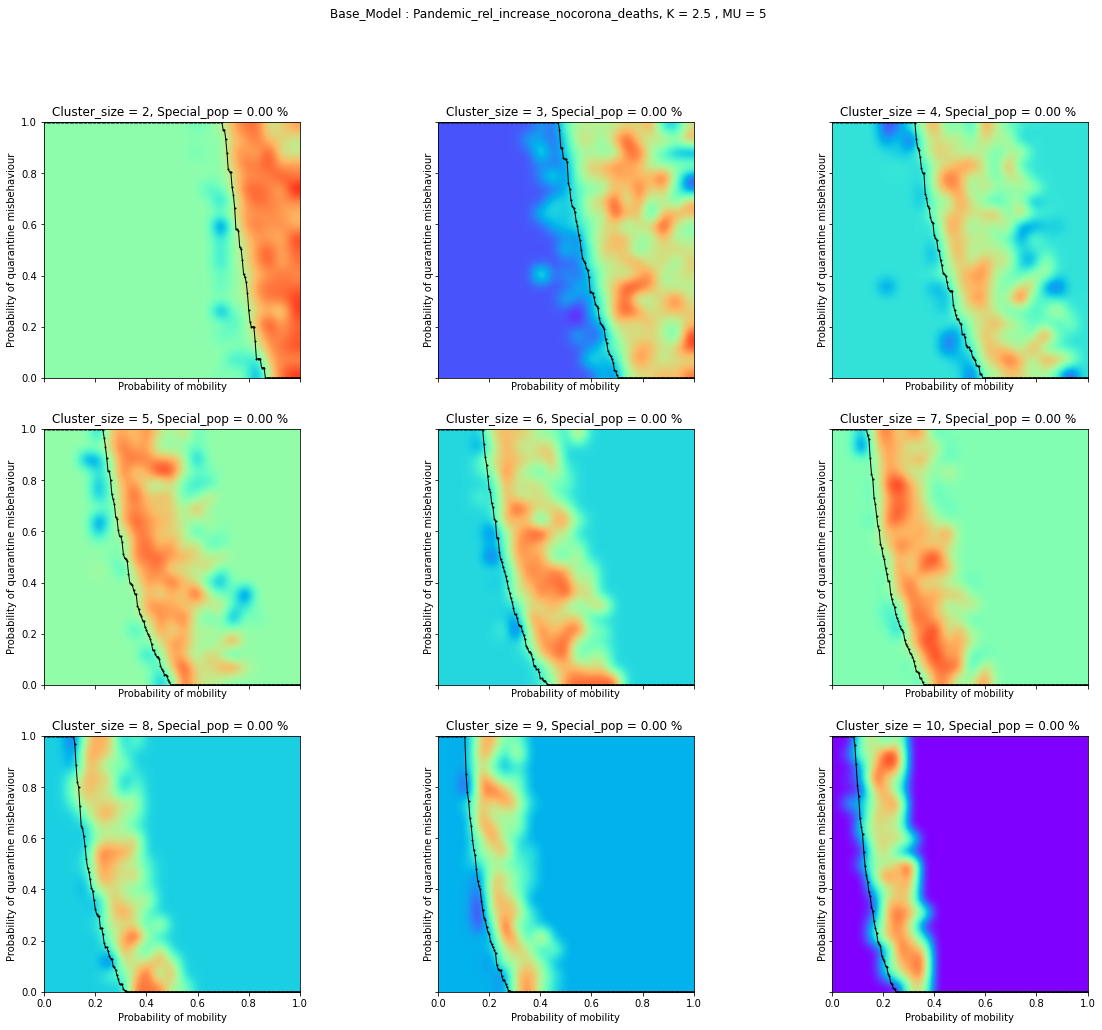

In [244]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def grid_grid_plot(cluster_dim,parameter,mu,k,extpop_list,type_ext,type_grid,interpolation):
    cnt=0
    initialpath=os.getcwd()
    #initialpath="/home/dorian/Codes/covid19"
    path_to_open="/outputs/"+type_ext+"_model"
    list_cluster_dict=[]
    list_cluster_dict_crit=[]
    for extpop in extpop_list:
        list_cluster_dict.append(get_files2(initialpath,path_to_open,mu,extpop,k))
        list_cluster_dict_crit.append(getfile_crit(initialpath,path_to_open,mu,extpop,k))

    name=get_name(parameter)
    file_title=(type_ext.capitalize() + "_Model : " + name + ", K = {}".format(k) + ' , MU = {}'.format(mu)) 
    
    sx=3
    sy=3
    fig, ax = plt.subplots(sx, sy, sharex='col', sharey='row')
    fig.suptitle(file_title)
    fig.set_size_inches(20, 16)
    for i in range(sx):
        for j in range(sy):
            cnt=cnt+1
            if type_grid=="extpop":
                out=arange_plot(cluster_dim[0],parameter,list_cluster_dict[sy*i+j],list_cluster_dict_crit[sy*i+j])
            if type_grid=="cluster":
                out=arange_plot(cluster_dim[sy*i+j],parameter,list_cluster_dict[0],list_cluster_dict_crit[0])
            
            if interpolation==1:         
                p1_crit=out[0]
                p2_crit=out[1]    
                implista_np=out[4]
                array=out[5]


                # Major ticks every 20, minor ticks every 5

                ax[i, j].imshow(array,interpolation="bicubic",cmap='rainbow',origin="lower",extent=[0,1,0,1])
                ax[i, j].plot(p1_crit, p2_crit, color="black", marker='o', linestyle='solid',linewidth=1, 
                              markersize=1)
                #implista_np=np.log10(implista_np)
                
                
                #ax[i, j].colorbar(label='INTENSITY MAP')
                #ax[i, j].clim(math.floor(min(implista_np)), math.ceil(max(implista_np)))

            else:
                p1_crit=out[0]
                p2_crit=out[1]
                p1_list_np=out[2]
                p2_list_np=out[3]
                implista_np=out[4]
                array=out[5]

                major_ticks = np.arange(0, 1.01, 0.1)
                minor_ticks = np.arange(0, 1.01, 0.05)
                ax[i, j].set_xticks(major_ticks)
                ax[i, j].set_xticks(minor_ticks, minor=True)
                ax[i, j].set_yticks(major_ticks)
                ax[i, j].set_yticks(minor_ticks, minor=True)

                ax[i, j].plot(p1_crit, p2_crit, color="black", marker='o', linestyle='solid',linewidth=1, 
                              markersize=1)
                #implista_np=np.log10(implista_np)
                ax[i, j].scatter(p1_list_np, p2_list_np, label=None,
                c=implista_np, cmap='rainbow', linewidth=12, alpha=5) #cmap='Accent' good alpha=5
                
        
            
            if type_grid=="extpop":
                e=float(extpop_list[sx*i+j])/10000
                ax[i, j].set_title("Cluster_size = {}".format(cluster_dim[0])
                                   +", Special_pop = {:.2f} % ".format(e))
            if type_grid=="cluster":
                e=float(extpop_list[0])/10000
                ax[i, j].set_title("Cluster_size = {}".format(cluster_dim[sy*i+j])
                                   +", Special_pop = {:.2f} % ".format(e))
            #if cnt==1 or cnt==3:
            ax[i, j].set_ylabel('Probability of quarantine misbehaviour')
            #if cnt==3 or cnt==4:
            ax[i, j].set_xlabel('Probability of mobility')
                
    plt.savefig("outputsBilj/"+file_title+'.png')

# cluster_dict : p1_dict : p2_dict : [seed_dict : [list of 8 elements], ratio_of_success_seeds]
        #0 first day of infectious case,1 length of pandemic (first infectious, last mild case),
        #2 peak of pandemic (max (infectious+mild+ic) ) 3 peak of pandemic known cases,
        #4 total corona deaths, 5 total no_corona deaths
        #6 number days in system overload ,7 first day system overload

mu=5 # 5, 100
k=2.5 # 1,2,5,10
#extpop_list=[100,1000,10000,100000] # [100],1000,10000,100000
extpop_list=[0,280000,10000,100000,280000]
cluster_dict={}
cluster_dict_crit={}
#clustdim=[8,7,8,9,10]
clustdim=[2,4,8,10]
clustdim=[2,3,4,5,6,7,8,9,10]
control_par=8
type_ext="base" # "superspreaders","base","domovi"
type_grid="cluster" #"extpop" ,"cluster"
interpolation=1

grid_grid_plot(clustdim,control_par,mu,k,extpop_list,type_ext,type_grid,interpolation)

In [162]:
from random import random
it=10000
r=0.1
days=15
duljina=np.zeros(it)
duljina1=np.zeros(it)
br_susjeda=3
vel_grozda=br_susjeda+1

p1_trip=1
k_trip=5

for k in range(it):
    grozd=np.zeros(br_susjeda)
    for j in range(0,days):
        for i in range(0,len(grozd)):
            if grozd[i]==0:
                grozd[i]=int(random()<=r)
            else:
                continue
    duljina[k]=np.sum(grozd)/len(grozd)
    duljina1[k]=np.sum(grozd)
    
print("velicina grozda = ",vel_grozda, "\nbroj susjeda = ",br_susjeda,
      "\nomjer zarazenih susjeda = ",np.mean(duljina), "\nbroj zarazenih susjeda = ",np.mean(duljina1),
     "\nR0 = ", p1_trip*days*k_trip/10 + np.mean(duljina1))

velicina grozda =  4 
broj susjeda =  3 
omjer zarazenih susjeda =  0.7926333333333332 
broj zarazenih susjeda =  2.3779 
R0 =  9.8779


In [23]:
from random import random
def R0simul(k_trip,vel_grozda,v):
    it=10000
    r=0.1
    days=15
    duljina=np.zeros(it)
    #br_susjeda=99
    br_susjeda=vel_grozda - 1
    #vel_grozda=br_susjeda+1

    broj_izlazaka=np.zeros(it)

    p1_trip=1
    #k_trip=5

    # simuliramo odkad je 1 (i samo 1) infectious u grozdu. 
    # simulacija traje days dana sto je broj dana inkubacije. Nakon toga dolazi karantena i ne gledamo.
    for k in range(it):
        grozd=np.zeros(br_susjeda) # svi susjedi su na pocetku susceptible
        for j in range(0,days):
            pomocni=grozd # uvedemo pomocni da se ne dogodi a-b b-c u istom danu.
            for i in range(0,len(grozd)): # idemo po svim susjedima prvog oboljelog
                if pomocni[i]==0: # ako nisu bolesni ...
                    for i1 in range(int(np.sum(pomocni))+1):
                        pomocni[i]+=int(random()<=r) # svi susjedi koji su vec zarazeni mogu zaraziti ...
                    pomocni[i]=min(1,pomocni[i]) 
                    if pomocni[i]==1: 
                        if v=="version1":
                            broj_izlazaka[k]=broj_izlazaka[k]+days-j-1
                        if v=="version2":
                            broj_izlazaka[k]=broj_izlazaka[k]+days-1    
                else:
                    continue
            grozd=pomocni
        broj_izlazaka[k]=broj_izlazaka[k]+days-1 # prvi bolesnik u grozdu ce putovati "days - 1" dana.
        duljina[k]=np.sum(grozd)/br_susjeda # tu spremamo sirenje pandemije unutar grozda.
    #print(duljina)
    #omjer_zarazenih_susjeda=0
    #broj_zarazenih_susjeda=0
    #broj_zarazenih_na_putovanju=0
    #ukupan_broj_zarazenih=0
    #R0=0

    omjer_zarazenih_susjeda=np.mean(duljina)
    broj_zarazenih_susjeda=np.mean(duljina)*br_susjeda
    broj_zarazenih_na_putovanju=np.mean(broj_izlazaka)*p1_trip*k_trip*r
    ukupan_broj_zarazenih=broj_zarazenih_susjeda+broj_zarazenih_na_putovanju
    R0=ukupan_broj_zarazenih/vel_grozda

    print("velicina grozda = ",vel_grozda, "\nbroj susjeda = ",br_susjeda,
          "\nomjer zarazenih susjeda = ",omjer_zarazenih_susjeda, "\nbroj zarazenih susjeda = ",broj_zarazenih_susjeda,
          "\nbroj zarazenih na putovanjima = ", broj_zarazenih_na_putovanju,
         "\nUkupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira = ",ukupan_broj_zarazenih,
         "\nR0 = ", R0)
    return R0

In [28]:
v="version2"
R0simul(2,2,v)

velicina grozda =  2 
broj susjeda =  1 
omjer zarazenih susjeda =  0.7928 
broj zarazenih susjeda =  0.7928 
broj zarazenih na putovanjima =  5.01984 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  5.81264 
R0 =  2.90632


2.90632

In [33]:
v="version2"
k_R0=[]
for cluster in np.arange(2,17,1):
    for k in np.arange(0,10.1,0.5):
        k_R0.append((k,R0simul(k,int(cluster),v),int(cluster)))
        print("\nCluster = {}, k = {}\n\n".format(cluster,k))

velicina grozda =  2 
broj susjeda =  1 
omjer zarazenih susjeda =  0.7847 
broj zarazenih susjeda =  0.7847 
broj zarazenih na putovanjima =  0.0 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  0.7847 
R0 =  0.39235

Cluster = 2, k = 0.0


velicina grozda =  2 
broj susjeda =  1 
omjer zarazenih susjeda =  0.7916 
broj zarazenih susjeda =  0.7916 
broj zarazenih na putovanjima =  1.2541200000000001 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  2.04572 
R0 =  1.02286

Cluster = 2, k = 0.5


velicina grozda =  2 
broj susjeda =  1 
omjer zarazenih susjeda =  0.7977 
broj zarazenih susjeda =  0.7977 
broj zarazenih na putovanjima =  2.5167800000000002 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  3.31448 
R0 =  1.65724

Cluster = 2, k = 1.0


velicina grozda =  2 
broj susjeda =  1 
omjer zarazenih susjeda =  0.788 
broj zarazenih susjeda =  0.788 
broj zarazenih na putovanjima =  3.7548000000000004 
Uku

velicina grozda =  3 
broj susjeda =  2 
omjer zarazenih susjeda =  0.88455 
broj zarazenih susjeda =  1.7691 
broj zarazenih na putovanjima =  15.506960000000001 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  17.27606 
R0 =  5.758686666666667

Cluster = 3, k = 4.0


velicina grozda =  3 
broj susjeda =  2 
omjer zarazenih susjeda =  0.8893 
broj zarazenih susjeda =  1.7786 
broj zarazenih na putovanjima =  17.50518 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  19.28378 
R0 =  6.427926666666667

Cluster = 3, k = 4.5


velicina grozda =  3 
broj susjeda =  2 
omjer zarazenih susjeda =  0.89305 
broj zarazenih susjeda =  1.7861 
broj zarazenih na putovanjima =  19.502700000000004 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  21.288800000000005 
R0 =  7.0962666666666685

Cluster = 3, k = 5.0


velicina grozda =  3 
broj susjeda =  2 
omjer zarazenih susjeda =  0.88995 
broj zarazenih susjeda =  1.7799 
b

velicina grozda =  4 
broj susjeda =  3 
omjer zarazenih susjeda =  0.9507666666666666 
broj zarazenih susjeda =  2.8523 
broj zarazenih na putovanjima =  40.44915 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  43.30145 
R0 =  10.8253625

Cluster = 4, k = 7.5


velicina grozda =  4 
broj susjeda =  3 
omjer zarazenih susjeda =  0.9492 
broj zarazenih susjeda =  2.8476 
broj zarazenih na putovanjima =  43.09312 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  45.94072 
R0 =  11.48518

Cluster = 4, k = 8.0


velicina grozda =  4 
broj susjeda =  3 
omjer zarazenih susjeda =  0.9506333333333334 
broj zarazenih susjeda =  2.8519000000000005 
broj zarazenih na putovanjima =  45.837610000000005 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  48.689510000000006 
R0 =  12.172377500000001

Cluster = 4, k = 8.5


velicina grozda =  4 
broj susjeda =  3 
omjer zarazenih susjeda =  0.9529333333333332 
broj zarazenih s

velicina grozda =  6 
broj susjeda =  5 
omjer zarazenih susjeda =  0.99256 
broj zarazenih susjeda =  4.9628 
broj zarazenih na putovanjima =  8.34792 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  13.31072 
R0 =  2.218453333333333

Cluster = 6, k = 1.0


velicina grozda =  6 
broj susjeda =  5 
omjer zarazenih susjeda =  0.9927 
broj zarazenih susjeda =  4.9635 
broj zarazenih na putovanjima =  12.52335 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  17.48685 
R0 =  2.914475

Cluster = 6, k = 1.5


velicina grozda =  6 
broj susjeda =  5 
omjer zarazenih susjeda =  0.99364 
broj zarazenih susjeda =  4.9681999999999995 
broj zarazenih na putovanjima =  16.71096 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  21.67916 
R0 =  3.6131933333333333

Cluster = 6, k = 2.0


velicina grozda =  6 
broj susjeda =  5 
omjer zarazenih susjeda =  0.99354 
broj zarazenih susjeda =  4.9677 
broj zarazenih na putovanjima

velicina grozda =  7 
broj susjeda =  6 
omjer zarazenih susjeda =  0.9977333333333334 
broj zarazenih susjeda =  5.9864 
broj zarazenih na putovanjima =  44.014320000000005 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  50.00072 
R0 =  7.14296

Cluster = 7, k = 4.5


velicina grozda =  7 
broj susjeda =  6 
omjer zarazenih susjeda =  0.9977333333333332 
broj zarazenih susjeda =  5.9864 
broj zarazenih na putovanjima =  48.9048 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  54.8912 
R0 =  7.8416

Cluster = 7, k = 5.0


velicina grozda =  7 
broj susjeda =  6 
omjer zarazenih susjeda =  0.99785 
broj zarazenih susjeda =  5.9871 
broj zarazenih na putovanjima =  53.800670000000004 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  59.78777 
R0 =  8.54111

Cluster = 7, k = 5.5


velicina grozda =  7 
broj susjeda =  6 
omjer zarazenih susjeda =  0.9972833333333334 
broj zarazenih susjeda =  5.983700000000001 


velicina grozda =  8 
broj susjeda =  7 
omjer zarazenih susjeda =  0.9993571428571429 
broj zarazenih susjeda =  6.995500000000001 
broj zarazenih na putovanjima =  89.5496 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  96.5451 
R0 =  12.0681375

Cluster = 8, k = 8.0


velicina grozda =  8 
broj susjeda =  7 
omjer zarazenih susjeda =  0.9994285714285713 
broj zarazenih susjeda =  6.9959999999999996 
broj zarazenih na putovanjima =  95.1524 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  102.1484 
R0 =  12.76855

Cluster = 8, k = 8.5


velicina grozda =  8 
broj susjeda =  7 
omjer zarazenih susjeda =  0.9992714285714286 
broj zarazenih susjeda =  6.9949 
broj zarazenih na putovanjima =  100.73574 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  107.73064000000001 
R0 =  13.466330000000001

Cluster = 8, k = 9.0


velicina grozda =  8 
broj susjeda =  7 
omjer zarazenih susjeda =  0.9993285714285713 
broj 

velicina grozda =  10 
broj susjeda =  9 
omjer zarazenih susjeda =  0.9999222222222223 
broj zarazenih susjeda =  8.9993 
broj zarazenih na putovanjima =  13.99902 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  22.99832 
R0 =  2.299832

Cluster = 10, k = 1.0


velicina grozda =  10 
broj susjeda =  9 
omjer zarazenih susjeda =  0.9999111111111111 
broj zarazenih susjeda =  8.9992 
broj zarazenih na putovanjima =  20.998320000000003 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  29.99752 
R0 =  2.999752

Cluster = 10, k = 1.5


velicina grozda =  10 
broj susjeda =  9 
omjer zarazenih susjeda =  0.9999555555555555 
broj zarazenih susjeda =  8.9996 
broj zarazenih na putovanjima =  27.998880000000003 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  36.99848 
R0 =  3.6998480000000002

Cluster = 10, k = 2.0


velicina grozda =  10 
broj susjeda =  9 
omjer zarazenih susjeda =  0.9999555555555555 
broj zaraze

velicina grozda =  11 
broj susjeda =  10 
omjer zarazenih susjeda =  0.9999899999999999 
broj zarazenih susjeda =  9.9999 
broj zarazenih na putovanjima =  69.29937 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  79.29926999999999 
R0 =  7.209024545454545

Cluster = 11, k = 4.5


velicina grozda =  11 
broj susjeda =  10 
omjer zarazenih susjeda =  0.9999899999999999 
broj zarazenih susjeda =  9.9999 
broj zarazenih na putovanjima =  76.9993 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  86.9992 
R0 =  7.909018181818182

Cluster = 11, k = 5.0


velicina grozda =  11 
broj susjeda =  10 
omjer zarazenih susjeda =  1.0 
broj zarazenih susjeda =  10.0 
broj zarazenih na putovanjima =  84.7 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  94.7 
R0 =  8.60909090909091

Cluster = 11, k = 5.5


velicina grozda =  11 
broj susjeda =  10 
omjer zarazenih susjeda =  0.9999899999999999 
broj zarazenih susjeda =  9.9

velicina grozda =  12 
broj susjeda =  11 
omjer zarazenih susjeda =  0.9999909090909092 
broj zarazenih susjeda =  10.9999 
broj zarazenih na putovanjima =  134.39888000000002 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  145.39878000000002 
R0 =  12.116565000000001

Cluster = 12, k = 8.0


velicina grozda =  12 
broj susjeda =  11 
omjer zarazenih susjeda =  0.9999909090909092 
broj zarazenih susjeda =  10.9999 
broj zarazenih na putovanjima =  142.79881 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  153.79871 
R0 =  12.816559166666666

Cluster = 12, k = 8.5


velicina grozda =  12 
broj susjeda =  11 
omjer zarazenih susjeda =  0.9999909090909092 
broj zarazenih susjeda =  10.9999 
broj zarazenih na putovanjima =  151.19874000000002 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  162.19864 
R0 =  13.516553333333334

Cluster = 12, k = 9.0


velicina grozda =  12 
broj susjeda =  11 
omjer zarazenih su

velicina grozda =  14 
broj susjeda =  13 
omjer zarazenih susjeda =  1.0 
broj zarazenih susjeda =  13.0 
broj zarazenih na putovanjima =  29.400000000000002 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  42.400000000000006 
R0 =  3.028571428571429

Cluster = 14, k = 1.5


velicina grozda =  14 
broj susjeda =  13 
omjer zarazenih susjeda =  1.0 
broj zarazenih susjeda =  13.0 
broj zarazenih na putovanjima =  39.2 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  52.2 
R0 =  3.7285714285714286

Cluster = 14, k = 2.0


velicina grozda =  14 
broj susjeda =  13 
omjer zarazenih susjeda =  1.0 
broj zarazenih susjeda =  13.0 
broj zarazenih na putovanjima =  49.0 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  62.0 
R0 =  4.428571428571429

Cluster = 14, k = 2.5


velicina grozda =  14 
broj susjeda =  13 
omjer zarazenih susjeda =  1.0 
broj zarazenih susjeda =  13.0 
broj zarazenih na putovanjima =  58.800

velicina grozda =  15 
broj susjeda =  14 
omjer zarazenih susjeda =  1.0 
broj zarazenih susjeda =  14.0 
broj zarazenih na putovanjima =  115.5 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  129.5 
R0 =  8.633333333333333

Cluster = 15, k = 5.5


velicina grozda =  15 
broj susjeda =  14 
omjer zarazenih susjeda =  1.0 
broj zarazenih susjeda =  14.0 
broj zarazenih na putovanjima =  126.0 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  140.0 
R0 =  9.333333333333334

Cluster = 15, k = 6.0


velicina grozda =  15 
broj susjeda =  14 
omjer zarazenih susjeda =  1.0 
broj zarazenih susjeda =  14.0 
broj zarazenih na putovanjima =  136.5 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  150.5 
R0 =  10.033333333333333

Cluster = 15, k = 6.5


velicina grozda =  15 
broj susjeda =  14 
omjer zarazenih susjeda =  1.0 
broj zarazenih susjeda =  14.0 
broj zarazenih na putovanjima =  147.0 
Ukupan broj zarazenih

velicina grozda =  16 
broj susjeda =  15 
omjer zarazenih susjeda =  1.0 
broj zarazenih susjeda =  15.0 
broj zarazenih na putovanjima =  224.0 
Ukupan broj zarazenih od grozdovih sudionika dok se grozd ne karantira =  239.0 
R0 =  14.9375

Cluster = 16, k = 10.0




In [35]:
pd.set_option('display.max_rows', 320)
R0frame = pd.DataFrame(k_R0, columns = ['K_trip' , 'R0', 'Cluster_size'])
columns_titles = ['Cluster_size','K_trip','R0']
R0frame=R0frame.reindex(columns=columns_titles)
R0frame

,Cluster_size,K_trip,R0
0,2,0.0,0.392350
1,2,0.5,1.022860
2,2,1.0,1.657240
3,2,1.5,2.271400
4,2,2.0,2.914490
5,2,2.5,3.533350
6,2,3.0,4.175320
7,2,3.5,4.793775
8,2,4.0,5.429440
9,2,4.5,6.038975


In [40]:
## 2.2-2.7
left=[2.47,6.31,2.32,2.28,2.39,2,1.4,1.96,2.89,1.5,5.71,1.4]
right=[2.86,6.66,3.63,3.67,4.13,3.1,2.5,2.55,4.39,3.5,7.23,3.9]
R0range=[0.8*np.mean(left), np.mean(right)*1.2]
print(R0range)
R0frame_imp = R0frame[(R0frame['R0'] >= R0range[0]) & (R0frame['R0'] <= R0range[1])]
R0frame_imp

[2.1753333333333336, 4.811999999999999]


,Cluster_size,K_trip,R0
3,2,1.5,2.271400
4,2,2.0,2.914490
5,2,2.5,3.533350
6,2,3.0,4.175320
7,2,3.5,4.793775
24,3,1.5,2.542743
25,3,2.0,3.188000
26,3,2.5,3.832317
27,3,3.0,4.484293
45,4,1.5,2.735533


In [237]:
ktrp=2.5
R0frame_imp = R0frame[(R0frame['K_trip'] >= ktrp) & (R0frame['K_trip'] <= ktrp)]
print(np.mean(R0frame_imp["R0"]))
R0frame_imp

NameError: name 'R0frame' is not defined